# **MASTER EN BLOCKCHAIN E INGENIERÍA DE DATOS (IEBS)**
## **·TRABAJO FINAL**

## *SMARTCHEF*: UN MODELO PREDICTIVO DE PRECIOS PARA HOSTELEROS IMPLEMENTADO EN UNA SOLUCIÓN DE BLOCKCHAIN

### **DAVID DEL RÍO CAMACHO**
### **18/09/2023**

# **NOTEBOOK DEL PROYECTO**

In [1]:
# Limpiar las variables del entorno
%reset -f

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import time
import itertools

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Flatten


# 1. IMPORTACIÓN DE DATOS Y ETIQUETAS

## 1.1 DICCIONARIO PARA ETIQUETAS DE ITEMS

In [3]:
coicop_labels = pd.read_excel("labels.xlsx", sheet_name="coicop")
coicop_labels

,label,description,value,(COICOP)
0,CP011,Food,1,CP011 Food
1,CP0111,Bread and cereals,2,CP0111 Bread and cereals
2,CP01113,Bread,3,CP01113 Bread
3,CP0112,Meat,4,CP0112 Meat
4,CP01121,Beef and veal,5,CP01121 Beef and veal
5,CP01122,Pork,6,CP01122 Pork
6,CP01123,Lamb and goat,7,CP01123 Lamb and goats
7,CP01124,Poultry,8,CP01124 Poultry
8,CP0113,Fish and seafood,9,CP0113 Fish and seafood
9,CP0114,"Milk, cheese and eggs",10,"CP0114 Milk, cheese and eggs"


In [4]:
geo_labels = pd.read_excel("labels.xlsx", sheet_name="geo")
geo_labels

,label,description,value
0,EU27_2020,European Union - 27 countries (from 2020),1
1,EU28,European Union - 28 countries (2013-2020),2
2,EA20,Euro area – 20 countries (from 2023),3
3,EA19,Euro area - 19 countries (2015-2022),4
4,BE,Belgium,5
5,BG,Bulgaria,6
6,CZ,Czechia,7
7,DK,Denmark,8
8,DE,Germany (until 1990 former territory of the FRG),9
9,EE,Estonia,10


In [5]:
indx_labels = pd.read_excel("labels.xlsx", sheet_name="indx")
indx_labels

,label,description,value
0,ACPI,Agricultural commodity price index,1
1,HICP,Harmonised index of consumer prices,2
2,PPI,Producer price index,3
3,IPI,Import price index,4


In [6]:
unit_labels = pd.read_excel("labels.xlsx", sheet_name="unit")
unit_labels

,label,description,value
0,I15,"Index, 2015=100",1
1,PCH_M12,Percentage change m/m-12,2


In [7]:
labels_dict = {}
labels_dict['coicop'] = {row[0]:{'description': row[1], 'value': row[2]} for row in coicop_labels.values}
labels_dict['geo'] = {row[0]:{'description': row[1], 'value': row[2]} for row in geo_labels.values}
labels_dict['indx'] = {row[0]:{'description': row[1], 'value': row[2]} for row in indx_labels.values}
labels_dict['unit'] = {row[0]:{'description': row[1], 'value': row[2]} for row in unit_labels.values}


## 1.2 IMPORTACIÓN DE REGISTROS

In [8]:
df = pd.read_csv("data/prc_fsc_idx_2005-2006.csv")
df1 = pd.read_csv("data/prc_fsc_idx_2007-2014.csv")
df2 = pd.read_csv("data/prc_fsc_idx_2015-2023.csv")
data = pd.concat([df, df1, df2], ignore_index=True)

# 2. ANÁLISIS DESCRIPTIVO PRELIMINAR

In [9]:
row, col = data.shape
print(f"El dataset original cuenta con {col} columnas y {row} registros")

El dataset original cuenta con 10 columnas y 933917 registros


In [10]:
data.head(5)

,DATAFLOW,LAST UPDATE,freq,unit,indx,coicop,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:PRC_FSC_IDX(1.0),01/07/23 11:00:00,M,I15,ACPI,CP011,AT,2005-01,88.5,e
1,ESTAT:PRC_FSC_IDX(1.0),01/07/23 11:00:00,M,I15,ACPI,CP011,AT,2005-02,87.4,e
2,ESTAT:PRC_FSC_IDX(1.0),01/07/23 11:00:00,M,I15,ACPI,CP011,AT,2005-03,87.2,e
3,ESTAT:PRC_FSC_IDX(1.0),01/07/23 11:00:00,M,I15,ACPI,CP011,AT,2005-04,87.8,e
4,ESTAT:PRC_FSC_IDX(1.0),01/07/23 11:00:00,M,I15,ACPI,CP011,AT,2005-05,86.4,e


In [11]:
# Valores únicos presentes en cada columna
data.agg(['nunique']).T

,nunique
DATAFLOW,1
LAST UPDATE,1
freq,1
unit,2
indx,4
coicop,26
geo,36
TIME_PERIOD,220
OBS_VALUE,14348
OBS_FLAG,10


In [12]:
#Eliminación de columnas carentes de información para el modelo
data.drop(columns=['DATAFLOW','LAST UPDATE','freq','OBS_FLAG'],inplace=True)

In [13]:
#Columnas con valores nulos
data.isnull().sum()

unit               0
indx               0
coicop             0
geo                0
TIME_PERIOD        0
OBS_VALUE      16740
dtype: int64

In [14]:
#Eliminación de registros sin valor observado
data.dropna(subset=['OBS_VALUE'],inplace=True)

In [15]:
# Tipo de variables
data.dtypes

unit            object
indx            object
coicop          object
geo             object
TIME_PERIOD     object
OBS_VALUE      float64
dtype: object

In [16]:
# Renombar columnas de tiempo y valor observado
data = data.rename(columns={'TIME_PERIOD':'time','OBS_VALUE':'value'})

In [17]:
# Conversión de 'time' a tipo datetime
data['time'] = pd.to_datetime(data['time'])

In [18]:
# Unidades de los registros. Un mismo registro puede estar duplicado con distinta unidad
data['unit'].unique()

array(['I15', 'PCH_M12'], dtype=object)

In [19]:
print(f"El dataset contiene {data.shape[0]} registros de los cuales:")
print(f"{data[data['unit'] == 'I15'].shape[0]} tienen unit I15")
print(f"{data[data['unit'] == 'PCH_M12'].shape[0]} tienen unit PCH_M12")

El dataset contiene 917177 registros de los cuales:
463504 tienen unit I15
453673 tienen unit PCH_M12


In [20]:
# Estadísticos variables cuantitativas
data[data['unit'] == 'PCH_M12'].describe().T

,count,mean,std,min,25%,50%,75%,max
value,453673.0,4.445932,16.632964,-92.1,-2.0,2.1,8.4,1493.7


In [21]:
# Estadísticos variables cuantitativas
data[data['unit'] == 'I15'].describe().T

,count,mean,std,min,25%,50%,75%,max
value,463504.0,102.218418,24.277332,13.2,91.27,100.28,109.3,934.7


# 3. ANÁLISIS DESCRIPTIVO DE VARIABLES

## 3.1 COICOP

In [22]:
# Contar la frecuencia de cada valor único
value_counts = data['coicop'].value_counts()
labels = [list(coicop_labels['description'][coicop_labels['label'] == i])[0] for i in value_counts.index]

print(f"{list(coicop_labels['description'][coicop_labels['label'] == value_counts.index[0]])[0]} es el indice con más registros {max(value_counts)}")
print(f"{list(coicop_labels['description'][coicop_labels['label'] == value_counts.index[-1]])[0]} es el indice con menos registros {min(value_counts)}")

Food es el indice con más registros 52280
Olive oil es el indice con menos registros 22515


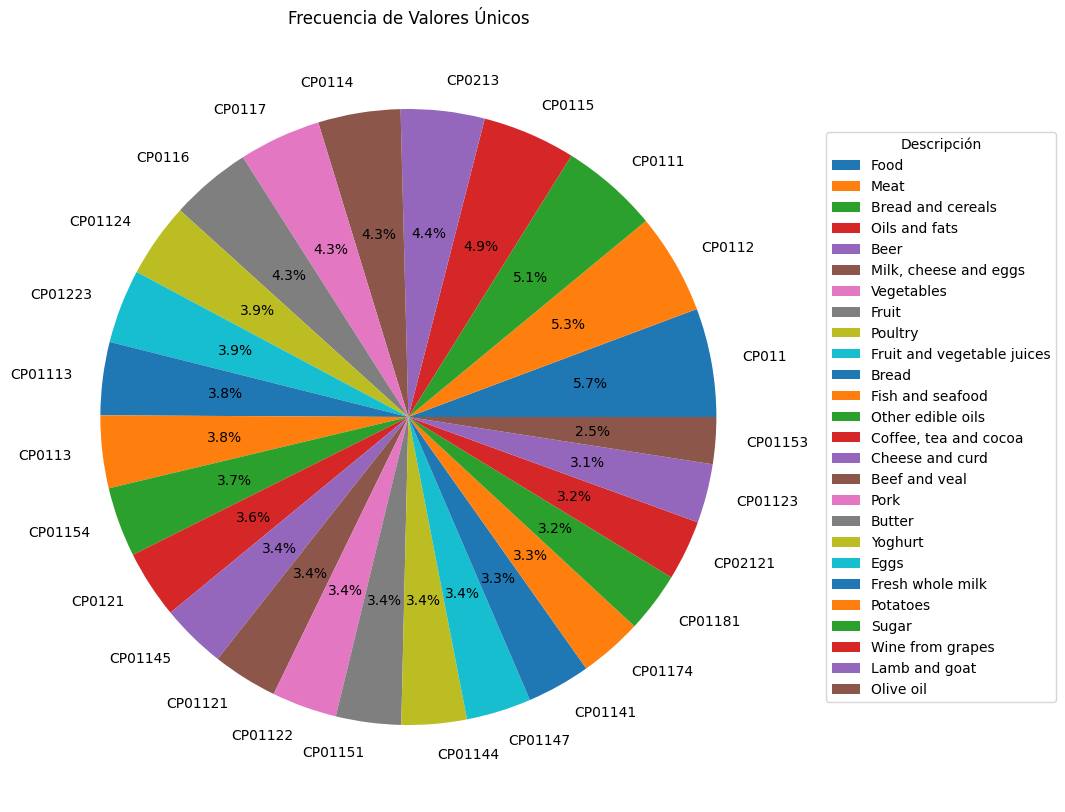

In [23]:
# Visualizar en un gráfico de tarta
plt.figure(figsize=(15, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Frecuencia de Valores Únicos')
plt.legend(labels,title='Descripción', bbox_to_anchor=(1.35, 0.5), loc='right')

plt.show()

El dataset original cuenta con un número símilar de registros en función del índice coicop, siendo el de mayor presencia el correspondiente al índice general de comida "CP011 - Food", seguido del índice "CP0112 - Meat". Por el contrario, los índices "CP01153 - Olive Oil" y "CP01123 - Lamb and goat" cuentan con el menor número de registros de todo el dataset en función de la etiqueta 'coicop'.

## 3.2 GEO

In [24]:
# Contar la frecuencia de cada valor único
value_counts = data['geo'].value_counts()
labels = [list(geo_labels['description'][geo_labels['label'] == i])[0] for i in value_counts.index]

print(f"{list(geo_labels['description'][geo_labels['label'] == value_counts.index[0]])[0]} es el país con más registros {max(value_counts)}")
print(f"{list(geo_labels['description'][geo_labels['label'] == value_counts.index[-1]])[0]} es el país con menos registros {min(value_counts)}")

France es el país con más registros 37295
Türkiye es el país con menos registros 6372


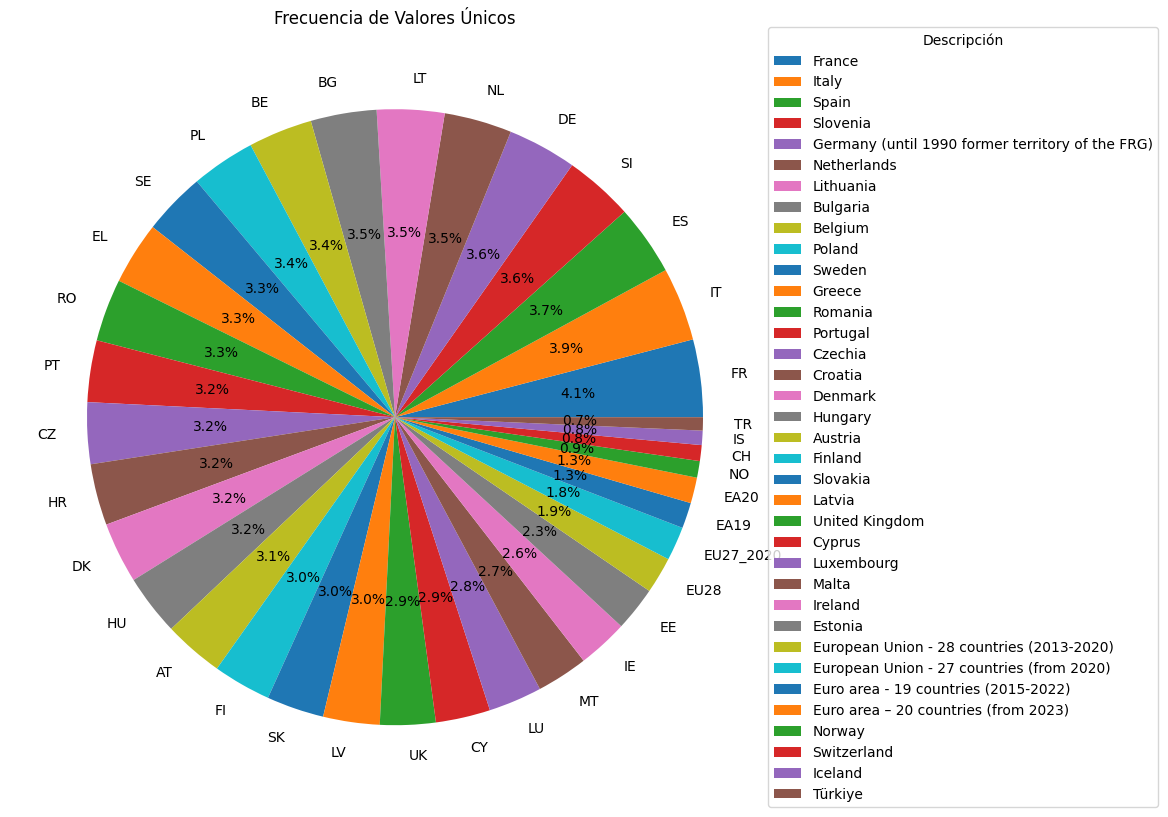

In [25]:
# Visualizar en un gráfico de tarta
plt.figure(figsize=(15, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Frecuencia de Valores Únicos')
plt.legend(labels,title='Descripción', bbox_to_anchor=(1.5, 0.5), loc='right')

plt.show()

El número de registros en función de la etiqueta 'geo' correspondiente a la nacionalidad, presenta mayor variabilidad que los datos agrupados por según el índice 'coicop'. Atendiendo a la naturaleza de los datos, la Unión Europea ha presentado cambios desde 2005 (inicio del dataset) en la estructura de los estados intervinientes, existiendo hasta la actualidad entradas y salidas de estados entre las que destaca la salida del Reino Unido en 2020.

- Los registros con etiqueta 'geo' TR, IS, CH y NO, no superan el 1% del conjunto.

- Los registros correspondientes a la Eurozona (EA_20 y EA-19) y Unión Europea (EU27_2020 y EU28) no superan el 2% de los registros, siendo después de las etiquetas anteriores aquellas con menor representación en el dataset. Estos valores además, representán la información del resto de estados de forma promediada, estando correlacionada con los propios registros de los estados y siendo lógica su exclusión del dataset de entrenamiento.

## 3.3 INDX

In [26]:
print(f"Número de registros ACPI - Agricultural commodity price index: {data[data['indx'] == 'ACPI'].shape[0]}")
print(f"Número de registros HICP - Harmonised index of consumer prices : {data[data['indx'] == 'HICP'].shape[0]}")
print(f"Número de registros PPI - Producer price index: {data[data['indx'] == 'PPI'].shape[0]}")
print(f"Número de registros IPI - Import price index: {data[data['indx'] == 'IPI'].shape[0]}")

Número de registros ACPI - Agricultural commodity price index: 253023
Número de registros HICP - Harmonised index of consumer prices : 271514
Número de registros PPI - Producer price index: 84093
Número de registros IPI - Import price index: 308547


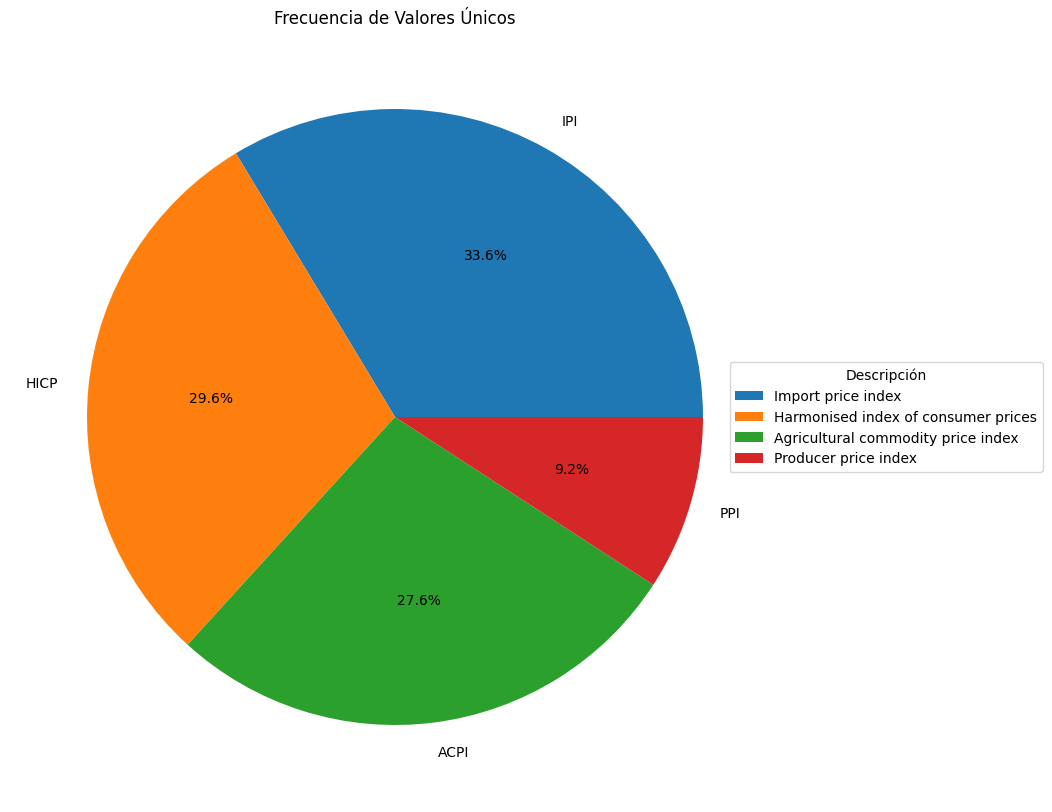

In [27]:
# Contar la frecuencia de cada valor único
value_counts = data['indx'].value_counts()
labels = [list(indx_labels['description'][indx_labels['label'] == i])[0] for i in value_counts.index]

# Visualizar en un gráfico de tarta
plt.figure(figsize=(20, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Frecuencia de Valores Únicos')
plt.legend(labels, title='Descripción', bbox_to_anchor=(1.35, 0.5), loc='right')

plt.show()

Dentro del ámbito del proyecto, el índice armonizado de precios al consumidor aporta la mayor coherencia de cara a su utilización en el dataset de entrenamiento. Posteriormente se definirá en base en la mejora de la variablidad del conjunto de datos.

### VISUALIZACIÓN DE REGISTROS CON ETIQUETAS CONCRETAS

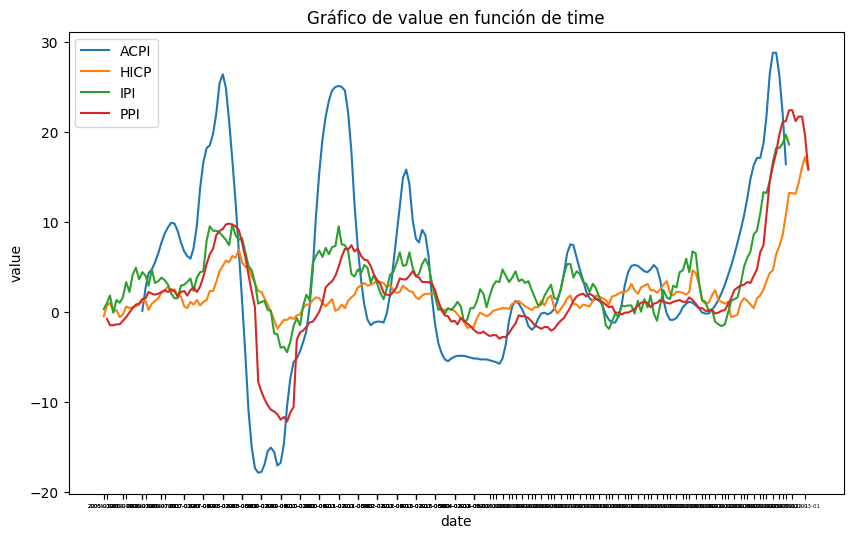

In [28]:
aux = data[(data['geo'] == 'FR') & (data['coicop'] == 'CP011' ) & (data['unit'] == 'PCH_M12' )]
aux.shape


fig = plt.figure(figsize=(10, 6))  # Aumentar el tamaño de la figura

unique_values = aux["indx"].unique()

# Crear el gráfico y asignar un color a cada línea basado en los valores únicos de "indx"
for value in unique_values:
    subset_df = aux[aux["indx"] == value]
    plt.plot(subset_df['time'], subset_df['value'], label=value)

# Personalizar el gráfico (opcional)
plt.title('Gráfico de value en función de time')
plt.xlabel('date')
plt.ylabel('value')
plt.legend()

# Mostrar solo 1 de cada 4 valores en el eje x
plt.xticks(aux['time'][::6],fontsize = 4)


# Mostrar el gráfico
plt.show()

# 4. SELECCIÓN DE DATASET

In [29]:
'''
Función para definir la variabilidad en función de tres métricas:

-Varianza
-Diferenciar entre tercer y primer cuartil
-Media de desviaciones (MAD)

'''



# Retorna un dataframe con 4 métricas de variabilidad de un dataframe
def measure_variability(df,label,scale_value):
    all = pd.DataFrame(index=df[label].unique(),columns=['varianza','iqr','MAD','N'])
    for col in df[label].unique():
        aux_df = df[df[label] == col]

        if scale_value == True:
          #Escalado de 'value'
          scaler = StandardScaler()
          aux_df['value'] = scaler.fit_transform(aux_df[['value']])

        # Calcular la varianza de los valores
        var = np.var(aux_df['value'])

        # Calcular la diferencia entre tercer y primer cuartil
        iqr_df = aux_df['value'].quantile(0.75) - aux_df['value'].quantile(0.25)

        # Calcular la media de desviaciones
        mad_df = (aux_df['value']-aux_df['value'].mean()).abs().mean()

        # Lista con las métricas
        all.loc[col][0:3] = [var,iqr_df,mad_df]

        # Número de registros en el subconjunto seleccionado
        all.loc[col][-1] = len(aux_df)

    return all

In [30]:
# Retorna una lista de etiquetas a eliminar que no pasan los filtros de variabilidad
def delete_label(var_metrics):
    geo_to_del = []
    n_qr1 = var_metrics.N.quantile(0.25)
    var_qr3 = var_metrics.varianza.quantile(0.75)
    iqr_qr3 = var_metrics.iqr.quantile(0.75)
    MAD_qr3 = var_metrics.MAD.quantile(0.75)

    for geo in var_metrics.index:
        if var_metrics.loc[geo][-1] < n_qr1:
            var_metrics.loc[geo][-1] = False
        if var_metrics.loc[geo][0] > var_qr3:
            var_metrics.loc[geo][0] = False
        if var_metrics.loc[geo][1] > iqr_qr3:
            var_metrics.loc[geo][1] = False
        if var_metrics.loc[geo][2] >  MAD_qr3:
            var_metrics.loc[geo][2] = False

        if sum(var_metrics.loc[geo] == False) >= 3:
            geo_to_del.append(geo)
    return geo_to_del


## 4.1 SELECCIÓN DE UNIDAD DEL DATASET

In [31]:
# Conteo de registros según el índice y la unidad
unit_len = {unit: {index: len(data[(data['unit'] == unit) & (data['indx'] == index )]) for index in data['indx'].unique()} for unit in data['unit'].unique()}

unit_len = pd.DataFrame(unit_len).T
unit_len['total'] = [sum(row) for row in unit_len.values]

unit_len.head()

,ACPI,HICP,IPI,PPI,total
I15,127863,138822,154482,42337,463504
PCH_M12,125160,132692,154065,41756,453673


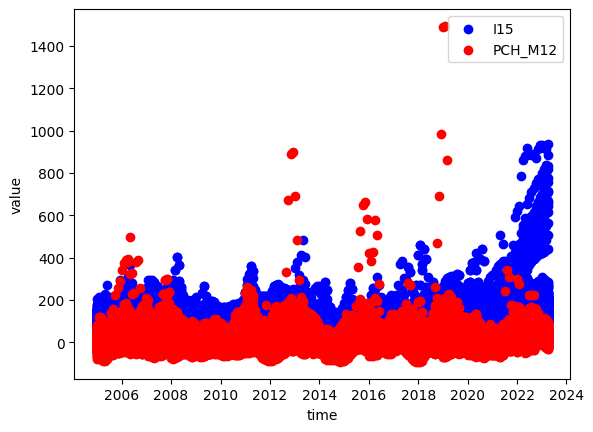

In [32]:
# Divide el DataFrame en dos subconjuntos según el valor de "unit"
unit_1_data = data[data['unit'] == 'I15']
unit_2_data = data[data['unit'] == 'PCH_M12']

# Crea el gráfico de dispersión para la primera unidad (en azul)
plt.scatter(unit_1_data['time'], unit_1_data['value'], c='blue', label='I15')

# Crea el gráfico de dispersión para la segunda unidad (en rojo)
plt.scatter(unit_2_data['time'], unit_2_data['value'], c='red', label='PCH_M12')

# Puedes personalizar el gráfico, como agregar etiquetas de ejes y leyendas
plt.xlabel('time')
plt.ylabel('value')
plt.legend()

# Muestra el gráfico
plt.show()

Ambas unidades cuentan con más de 450 mil registros, pudiendo a priori pensar que el número de registros no es un factor limitante en nínguno de los subconjuntos

Se analiza el grado de variabilidad de ambos subconjuntos, los registros con unidad absoluta (I15) y los registros con unidad porcentual (PCH_M12).

Se escogera preferiblemente el que menor grado de variabilidad
muestre, por ofrecer con menor ruido y con mayor potencial para el entrenamiento del modelo.

Para ello se analizan tres parámetros en los dos subconjuntos tras estandarizar la columna 'value' por separado en ambos grupos:

1. Varianza
2. Diferencia entre tercer y primer cuartil
2. Desviación media absoluta
3. Número de registros del subconjunto


In [33]:
var_metrics_unit = measure_variability(data,'unit',True)

C:\Users\David\AppData\Local\Temp\ipykernel_7052\2932927206.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['value'] = scaler.fit_transform(aux_df[['value']])
C:\Users\David\AppData\Local\Temp\ipykernel_7052\2932927206.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['value'] = scaler.fit_transform(aux_df[['value']])


In [34]:
print(var_metrics_unit)

        varianza       iqr       MAD       N
I15          1.0  0.742669  0.595868  463504
PCH_M12      1.0  0.625265  0.582954  453673


De las tres métricas propuestas para estimar la variabilidad del valor value del dataset en función de la columna 'unit', se desprende que el subconjunto óptimo para el modelo a falta de otros filtrados y tratamientos de datos es el formado por 'unit' = 'PCH_M12', que expresa value como variaciones porcentuales mensuales.

In [35]:
delete_label(var_metrics_unit)

['I15']

In [36]:
model_data = data[data['unit'] == 'PCH_M12'].drop(columns='unit',axis=1)

In [37]:
print(f"El tamaño inicial era {data.shape[0]} registros")
print(f"Se eliminan {data.shape[0]-model_data.shape[0]} registros tras el filtrado")
print(f"El tamaño final del dataset es {model_data.shape[0]}")

El tamaño inicial era 917177 registros
Se eliminan 463504 registros tras el filtrado
El tamaño final del dataset es 453673


In [38]:
model_data.head()

,indx,coicop,geo,time,value
46291,ACPI,CP011,AT,2006-01-01,0.5
46292,ACPI,CP011,AT,2006-02-01,5.1
46293,ACPI,CP011,AT,2006-03-01,6.6
46294,ACPI,CP011,AT,2006-04-01,5.0
46295,ACPI,CP011,AT,2006-05-01,4.8


## 4.2 SELECCIÓN DE ÍNDICE INDX MÁS REPRESENTATIVO

In [39]:
var_metrics_indx = measure_variability(model_data,'indx',False)

In [40]:
aux = model_data

In [41]:
print(var_metrics_indx)

        varianza   iqr        MAD       N
ACPI  621.308946  17.2  14.774463  125160
HICP   89.112528   5.9   5.692661  132692
IPI    197.48322  13.1   9.776151  154065
PPI   126.667928   6.7   6.668494   41756


In [42]:
model_data = model_data[model_data['indx'] == 'HICP'].drop(columns='indx',axis=1)

In [43]:
print(f"El tamaño inicial era {aux.shape[0]} registros")
print(f"Se eliminan {aux.shape[0]-model_data.shape[0]} registros")
print(f"El tamaño final del dataset es {model_data.shape[0]}")

El tamaño inicial era 453673 registros
Se eliminan 320981 registros
El tamaño final del dataset es 132692


In [44]:
model_data.head()

,coicop,geo,time,value
58618,CP011,AT,2005-01-01,0.8
58619,CP011,AT,2005-02-01,2.1
58620,CP011,AT,2005-03-01,2.3
58621,CP011,AT,2005-04-01,1.4
58622,CP011,AT,2005-05-01,0.5


In [45]:
# Variación de la varianza del modelo
var_diff = np.var(model_data['value'])-np.var(aux['value'])
print(f"La diferencia en las métricas entre el conjunto inicial y las etiquetas eliminadas es:")
print(var_diff)

La diferencia en las métricas entre el conjunto inicial y las etiquetas eliminadas es:
-187.54234669272537


## 4.3 FILTRADO VARIABLE GEO

In [46]:
# Llamada a funciones de filtrado
var_metrics_geo = measure_variability(model_data,'geo',False)
print(var_metrics_geo)

             varianza    iqr        MAD     N
AT          41.582034    4.6   4.143678  3895
BE          53.399458    4.8   4.608238  5544
BG         132.431201    8.2   7.626534  4008
CH          11.146767    3.2   2.344166  3442
CY         162.096534    6.4   6.746035  3432
CZ         134.262047    8.2   7.464546  3535
DE          87.101599    5.2   5.628046  3624
DK          66.169261    6.1   5.189473  4584
EA19        45.113823    3.7    4.06836  3240
EA20         44.79195    3.7   4.071833  3240
EE         189.185865   10.1   8.846845  3355
EL          54.518571    5.4   5.013209  3624
ES          69.164817    4.5   4.949024  3432
EU27_2020   52.347738    4.0   4.520377  3240
EU28        14.471795    3.1   2.450147  2226
FI          51.212369    6.1   4.957327  3110
FR          27.128938    3.2   3.088164  5577
HR          78.393309    6.7   5.941445  3432
HU         186.594821   8.75   8.824045  3535
IE          31.046899    4.3    3.81223  3240
IS          64.301538    7.2   5.3

In [47]:
geo_to_del = delete_label(var_metrics_geo)

# Añadimos a la lista de etiquetas a eliminar las correspondiente a Eurozona, Unión Europea y UK
geo_to_del.extend(['EA20','EA19','EU27_2020','EU28'])

obs_to_del = sum([model_data[model_data['geo'] == geo].shape[0] for geo in geo_to_del])

In [48]:
print(f"Los registros de los siguientes países muestran una varianza muy superior al resto:")
print(geo_to_del)
print(f"Se propone eliminación de: {obs_to_del} registros ({round(obs_to_del*100/model_data.shape[0],2)}% del total)")

Los registros de los siguientes países muestran una varianza muy superior al resto:
['BG', 'CZ', 'EE', 'HU', 'LT', 'LV', 'SK', 'TR', 'EA20', 'EA19', 'EU27_2020', 'EU28']
Se propone eliminación de: 40957 registros (30.87% del total)


In [49]:
#Media de las métricas de variablidad
var_metrics_geo_mean  =  measure_variability(model_data,'geo',False).mean()
var_metrics_geo_filtered_mean  = measure_variability(model_data[~model_data['geo'].isin(geo_to_del)],'geo',False).mean()
mean_diff = var_metrics_geo_filtered_mean-var_metrics_geo_mean
print(mean_diff)

varianza    -24.921439
iqr          -0.785764
MAD          -0.764107
N           136.402778
dtype: float64


In [50]:
# Variación de la varianza del modelo
var_diff = np.var(model_data[~model_data['geo'].isin(geo_to_del)]['value'])-np.var(model_data['value'])
print(f"La diferencia en las métricas entre el conjunto inicial y las etiquetas eliminadas es:")
print(var_diff)

La diferencia en las métricas entre el conjunto inicial y las etiquetas eliminadas es:
-26.005743753133935


Con la eliminación de los registros correspondientes a las naciones anteriores dada su significativa superioridad de las métricas de varianza, se obtendrían mejoras en todas las métricas:

- La media de la varianza por etiqueta 'geo' se ha reducido.
- La media de la diferencia entre el primer y tercer cuartil, y la media de desviaciones (MAD) por etiqueta 'geo' se han reducido.
- La media del promedio de registros por etiqueta 'geo' ha aumentado por más de 135 registros de media.
- La varianza promedio en todo el dataset ha mejorado más de 25 puntos.

In [51]:
model_data = model_data[~model_data['geo'].isin(geo_to_del)]
model_data.shape

(91735, 4)

## 4.4 FILTRADO VARIABLE COICOP

In [52]:
# Llamada a funciones de filtrado
var_metrics_coicop  = measure_variability(model_data,'coicop',False)
print(var_metrics_coicop)

           varianza   iqr        MAD     N
CP011     17.049424   3.4   2.779136  5240
CP0111    23.192435   3.4   3.204782  5240
CP01113   31.282609   3.4   3.758814  2525
CP0112    18.382985   3.5   2.902076  5240
CP01121    29.57406   3.6   3.625164  2525
CP01122    32.37988   5.5   4.078006  2525
CP01123   40.428418   5.6   4.508546  1999
CP01124   50.976178   4.6   4.777376  2525
CP0113    22.663594   4.1   3.189465  5240
CP0114    35.138562   4.3   3.914802  5240
CP01141   73.050942   5.7   5.816114  2400
CP01144   42.545489   5.1   4.518779  2525
CP01145    47.98412   4.2   4.485098  2525
CP01147   83.434757   6.4   6.258663  2525
CP0115    80.690811   7.6   6.235708  5240
CP01151  130.196836  11.5   8.507398  2525
CP01153   61.725386   8.3   5.751558  2392
CP01154  260.224359   8.8  10.817425  2488
CP0116     51.51025   7.7   5.131953  5240
CP0117    72.081666   8.8   6.038691  5240
CP01174  417.281235  16.5   13.09268  2382
CP01181  189.954814   6.7   8.182827  2525
CP0121    3

In [53]:
# Obtención de etiquetas con mayor nivel de ruido
coicop_to_del = delete_label(var_metrics_coicop)
obs_to_del = sum([model_data[model_data['coicop'] == coicop].shape[0] for coicop in coicop_to_del])

In [54]:
print(f"Los registros de los siguientes alimentos muestran una varianza muy superior al resto:")
print(coicop_to_del)
print(f"Se propone eliminación de: {obs_to_del} registros ({round(obs_to_del*100/len(model_data),2)}% del total)")

Los registros de los siguientes alimentos muestran una varianza muy superior al resto:
['CP0115', 'CP01151', 'CP01154', 'CP01174']
Se propone eliminación de: 12635 registros (13.77% del total)


In [55]:
#Media de las métricas de variablidad
var_metrics_coicop_mean  = measure_variability(model_data,'coicop',False).mean()
var_metrics_coicop_filtered_mean  = measure_variability(model_data[~model_data['coicop'].isin(coicop_to_del)],'coicop',False).mean()
mean_diff = var_metrics_coicop_filtered_mean-var_metrics_coicop_mean
print(mean_diff)

varianza   -27.153267
iqr         -0.938462
MAD         -0.822606
N           67.185315
dtype: float64


In [56]:
# Variación de la varianza del modelo
var_diff = np.var(model_data[~model_data['coicop'].isin(coicop_to_del)]['value'])-np.var(model_data['value'])
print(f"La varianza global del modelo variaría {var_diff}")

La varianza global del modelo variaría -21.277595047418323


Dado que se obtienen mejoras significativas en la varianza global del dataset filtrado, así como el resto de métricas mejorando inclusive el número de muestras promedio de cada grupo correspondiente a una etiqueta coicop, se procede a la eliminación de los registros correspondientes a las etiquetas detectadas.


In [57]:
model_data = model_data[~model_data['coicop'].isin(coicop_to_del)]
model_data.shape

(79100, 4)

## 4.5 FILTRADO GENERAL DE DATOS

In [58]:
def clean_outliers_data(df, num_std_dev,period):
    # Agrupar por mes y calcular la media y desviación estándar
    monthly_stats = df.groupby(df['time'].dt.to_period(period))['value'].agg(['mean', 'std'])

    # Renombrar las columnas para mayor claridad
    monthly_stats.columns = ['monthly_mean', 'monthly_std']

    # Unir las estadísticas mensuales con el DataFrame original
    df = df.merge(monthly_stats, left_on=df['time'].dt.to_period(period), right_index=True)

    # Calcular las bandas de Bollinger para cada mes
    df['upper_band'] = df['monthly_mean'] + num_std_dev * df['monthly_std']
    df['lower_band'] = df['monthly_mean'] - num_std_dev * df['monthly_std']

    # Filtrar el DataFrame para eliminar valores atípicos
    cleaned_df = df[(df['value'] >= df['lower_band']) & (df['value'] <= df['upper_band'])]
    outliers = df[(df['value'] < df['lower_band']) | (df['value'] > df['upper_band'])]

    return cleaned_df,outliers


In [59]:
def plot_trust_interval(df_q,outliers_q, df_m,outliers_m):
    # Crear dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12),sharex=True)

    # Subplot para el período trimestral
    ax1.scatter(df_q['time'], df_q['value'], label='Datos intervalo confianza (Trimestral)', color='blue', alpha=0.1)
    ax1.scatter(outliers_q['time'], outliers_q['value'], label='Datos fuera del intervalo de confianza (Trismetral)', color='red', marker='x',alpha=0.3)
    ax1.plot(df_q['time'], df_q['upper_band'], label='Banda de Bollinger Superior (Trimestral)', color='red', linestyle='--')
    ax1.plot(df_q['time'], df_q['lower_band'], label='Banda de Bollinger Inferior (Trimestral)', color='green', linestyle='--')

    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Valor')
    ax1.set_title('Intervalos de confianza (Trimestral)')
    ax1.legend()
    ax1.grid(True)

    # Subplot para el período mensual
    ax2.scatter(df_m['time'], df_m['value'], label='Datos intervalo confianza (Mensual)', color='blue', alpha=0.1)
    ax2.scatter(outliers_m['time'], outliers_m['value'], label='Datos fuera del intervalo de confianza (Mensual)', color='red', marker='x',alpha=0.3)
    ax2.plot(df_m['time'], df_m['upper_band'], label='Banda de Bollinger Superior (Mensual)', color='red', linestyle='--')
    ax2.plot(df_m['time'], df_m['lower_band'], label='Banda de Bollinger Inferior (Mensual)', color='green', linestyle='--')

    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Valor')
    ax2.set_title('Intervalos de confianza (Mensual)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


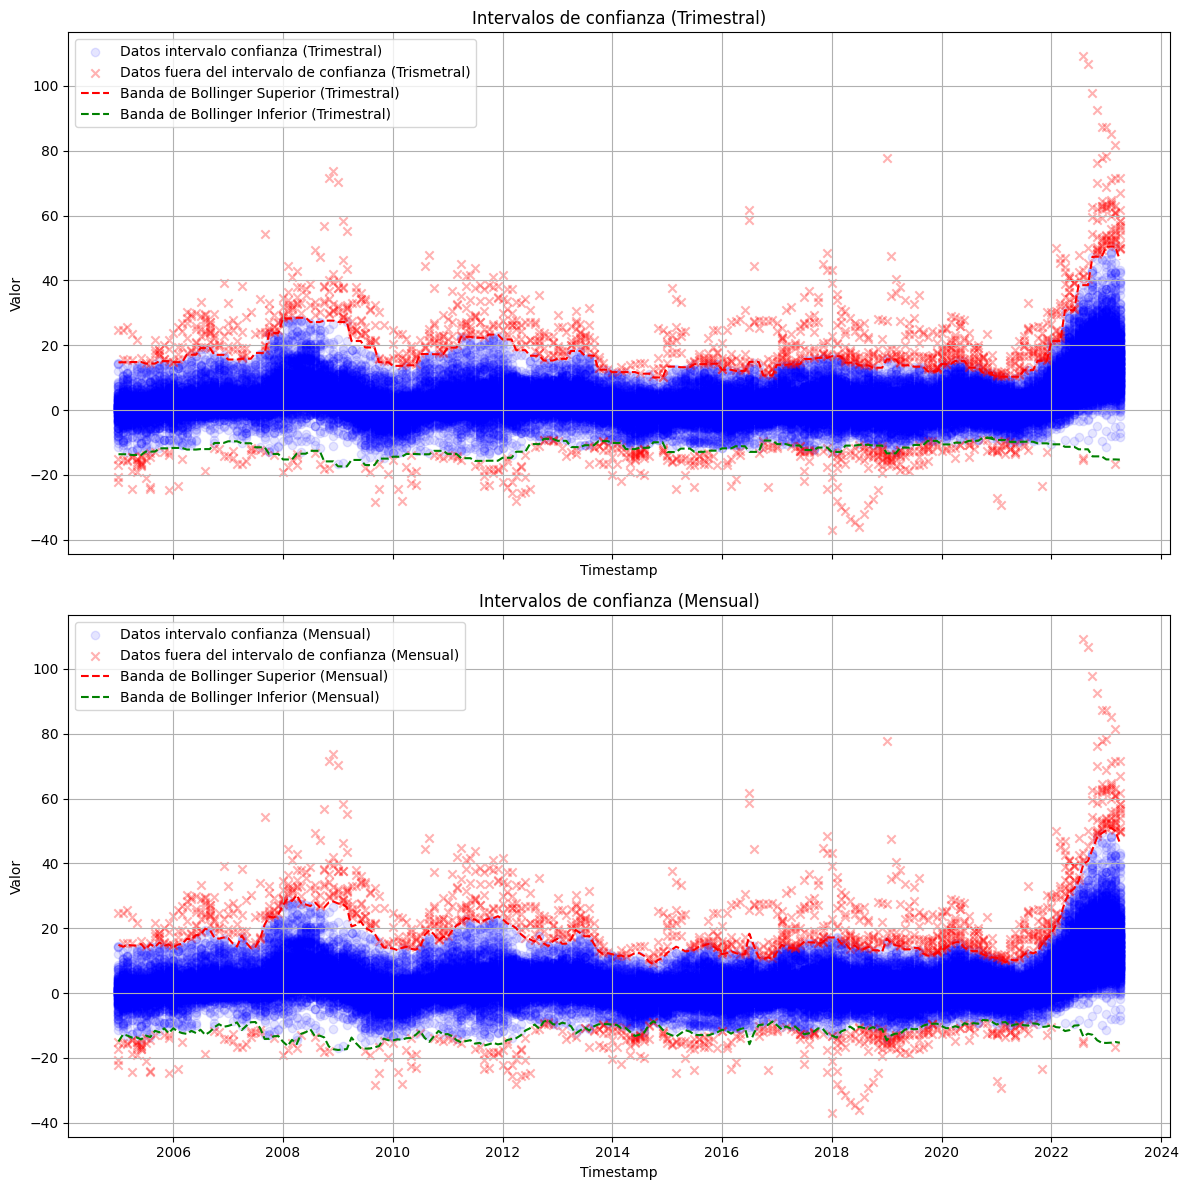

In [60]:
# Filtrado a partir
df_q,out_q = clean_outliers_data(model_data,num_std_dev=3,period='Q')
df_m,out_m = clean_outliers_data(model_data,num_std_dev=3,period='M')

# Ploteado de puntos dentro y fuera de rango de confianza
plot_trust_interval(df_q,out_q,df_m,out_m)


In [61]:
print(f"{model_data.shape[0]-df_m.shape[0]} registros están fuera del intervalo 3*desv.std de los valores de cada mes")

1511 registros están fuera del intervalo 3*desv.std de los valores de cada mes


In [62]:
var_diff = np.var(df_m['value'])-np.var(model_data['value'])
print(f"La varianza global del modelo ha variado en {var_diff}")
print(f"La varianza final del modelo es de {np.var(df_m['value'])}")

La varianza global del modelo ha variado en -11.309915473615838
La varianza final del modelo es de 30.519273964541945


In [63]:
model_data = df_m.drop(columns=['key_0','upper_band','lower_band','monthly_mean', 'monthly_std'],axis=1)
print(f"El tamaño final del dataset es de: {model_data.shape}")

El tamaño final del dataset es de: (77589, 4)


# 5. ESTANDARIZACIÓN DE VARIABLE VALUE

In [64]:
model_data.head()

,coicop,geo,time,value
58618,CP011,AT,2005-01-01,0.8
58642,CP011,BE,2005-01-01,0.8
58703,CP011,CY,2005-01-01,3.5
58751,CP011,DE,2005-01-01,-1.1
58775,CP011,DK,2005-01-01,-1.5


In [65]:
# Crear un objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar la columna 'value' para estandarizarla
model_data['value'] = scaler.fit_transform(model_data['value'].values.reshape(-1,1))
np.var(model_data['value'])

1.0

In [66]:
model_data.head()

,coicop,geo,time,value
58618,CP011,AT,2005-01-01,-0.354934
58642,CP011,BE,2005-01-01,-0.354934
58703,CP011,CY,2005-01-01,0.133804
58751,CP011,DE,2005-01-01,-0.698862
58775,CP011,DK,2005-01-01,-0.771267


# 6. TRANSFORMACIÓN DE VARIABLES CATEGÓRICAS

## 6.1 ORDINAL ENCODED

In [67]:
ordinal_encoded = model_data

le = LabelEncoder()
ordinal_encoded['coicop'] = le.fit_transform(model_data['coicop'])
ordinal_encoded['geo'] = le.fit_transform(model_data['geo'])
ordinal_encoded.head()

,coicop,geo,time,value
58618,0,0,2005-01-01,-0.354934
58642,0,1,2005-01-01,-0.354934
58703,0,3,2005-01-01,0.133804
58751,0,4,2005-01-01,-0.698862
58775,0,5,2005-01-01,-0.771267


In [68]:
ordinal_encoded.shape

(77589, 4)

## 6.2 ONE HOT ENCODING

In [69]:
dummies_encoded = pd.get_dummies(model_data, columns=['coicop', 'geo'])
dummies_encoded.head()

,time,value,coicop_0,coicop_1,coicop_2,coicop_3,coicop_4,coicop_5,coicop_6,coicop_7,...,geo_14,geo_15,geo_16,geo_17,geo_18,geo_19,geo_20,geo_21,geo_22,geo_23
58618,2005-01-01,-0.354934,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58642,2005-01-01,-0.354934,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58703,2005-01-01,0.133804,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58751,2005-01-01,-0.698862,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58775,2005-01-01,-0.771267,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
dummies_encoded.shape

(77589, 48)

## 6.3 SELECCIÓN DE MÉTODO

In [71]:
def create_and_fit_prophet_model(df,train_size):
    # Creación de modelo
    model = Prophet()
    for column_name in df.columns:
        if column_name not in ['ds','y']:
            model.add_regressor(column_name)

    # Split de datos
    df_train, df_test = train_test_split(df, test_size=1 - train_size, shuffle=True, random_state=4)

    df_train.head()

    # Entrenamiento
    model.fit(df_train)

    # Resumen del modelo
    print(model)

    # Evaluación
    forecast = model.predict(df_test)

    # Realiza la validación cruzada
    df_cv = cross_validation(model, initial=f'{365*10} days', period=f'{30} days', horizon=f'{365} days')
    df_p = performance_metrics(df_cv)

    # Ploteado de predicciones
    model.plot(forecast,xlabel='Time',ylabel='HICP standarized',include_legend=True,uncertainty=True)

    return df_cv,df_p

15:13:36 - cmdstanpy - INFO - Chain [1] start processing
15:13:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/89 [00:00<?, ?it/s]

15:13:36 - cmdstanpy - INFO - Chain [1] start processing
15:13:36 - cmdstanpy - INFO - Chain [1] done processing
15:13:36 - cmdstanpy - INFO - Chain [1] start processing
15:13:36 - cmdstanpy - INFO - Chain [1] done processing
15:13:37 - cmdstanpy - INFO - Chain [1] start processing
15:13:37 - cmdstanpy - INFO - Chain [1] done processing
15:13:37 - cmdstanpy - INFO - Chain [1] start processing
15:13:37 - cmdstanpy - INFO - Chain [1] done processing
15:13:37 - cmdstanpy - INFO - Chain [1] start processing
15:13:37 - cmdstanpy - INFO - Chain [1] done processing
15:13:37 - cmdstanpy - INFO - Chain [1] start processing
15:13:37 - cmdstanpy - INFO - Chain [1] done processing
15:13:38 - cmdstanpy - INFO - Chain [1] start processing
15:13:38 - cmdstanpy - INFO - Chain [1] done processing
15:13:38 - cmdstanpy - INFO - Chain [1] start processing
15:13:38 - cmdstanpy - INFO - Chain [1] done processing
15:13:38 - cmdstanpy - INFO - Chain [1] start processing
15:13:38 - cmdstanpy - INFO - Chain [1]

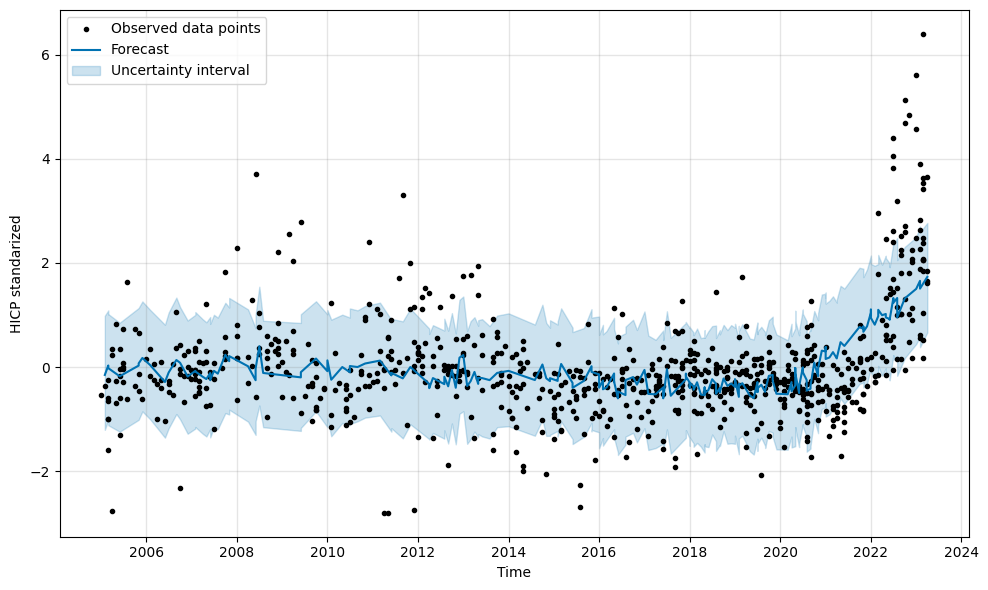

In [72]:
# Crear y entrenar el modelo Prophet con LabelEncoder
ordinal_encoded.rename(columns={'time': 'ds', 'value': 'y'}, inplace=True)
df_cv,df_p_or = create_and_fit_prophet_model(ordinal_encoded.sample(n=1000, random_state=42),0.8)

15:13:58 - cmdstanpy - INFO - Chain [1] start processing
15:13:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/89 [00:00<?, ?it/s]

15:13:58 - cmdstanpy - INFO - Chain [1] start processing
15:13:58 - cmdstanpy - INFO - Chain [1] done processing
15:13:59 - cmdstanpy - INFO - Chain [1] start processing
15:13:59 - cmdstanpy - INFO - Chain [1] done processing
15:13:59 - cmdstanpy - INFO - Chain [1] start processing
15:13:59 - cmdstanpy - INFO - Chain [1] done processing
15:13:59 - cmdstanpy - INFO - Chain [1] start processing
15:13:59 - cmdstanpy - INFO - Chain [1] done processing
15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:00 - cmdstanpy - INFO - Chain [1] done processing
15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:00 - cmdstanpy - INFO - Chain [1] done processing
15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:00 - cmdstanpy - INFO - Chain [1] done processing
15:14:01 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1] done processing
15:14:01 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1]

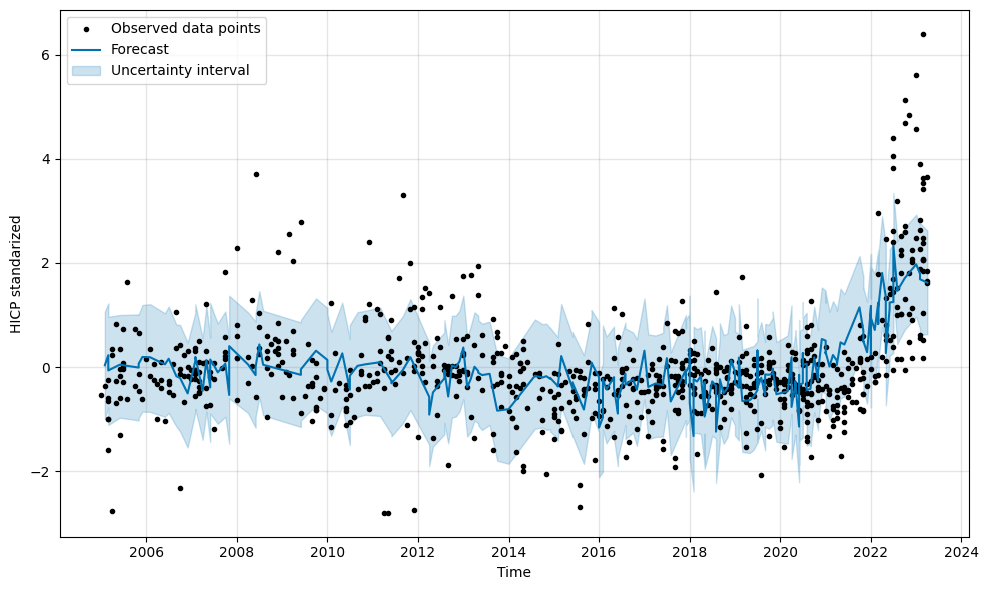

In [73]:
dummies_encoded.rename(columns={'time': 'ds', 'value': 'y'}, inplace=True)
df_cv,df_p_dumm = create_and_fit_prophet_model(dummies_encoded.sample(n=1000, random_state=42),0.8)

In [74]:
metrics = pd.DataFrame([df_p_or.mean(),df_p_dumm.mean()],index=['Ordical enconded','One-Hot Enconding']).drop(columns='horizon',axis=1)
metrics

,mse,rmse,mae,mape,mdape,smape,coverage
Ordical enconded,0.924891,0.942498,0.601227,2.882465,0.820886,1.094587,0.841461
One-Hot Enconding,1.063496,1.013736,0.671081,3.727402,1.030982,1.220318,0.781438


In [75]:
model_data = ordinal_encoded
model_data.head()

,coicop,geo,ds,y
58618,0,0,2005-01-01,-0.354934
58642,0,1,2005-01-01,-0.354934
58703,0,3,2005-01-01,0.133804
58751,0,4,2005-01-01,-0.698862
58775,0,5,2005-01-01,-0.771267


# 7. SELECCIÓN DE MODELO

## 7.1 SELECCIÓN DE ALGORITMO

In [76]:
data_to_select_model = model_data.sample(model_data.shape[0]//20,random_state = 19)
data_to_select_model.head()

,coicop,geo,ds,y
794405,10,15,2017-07-01,-0.499746
829992,18,7,2022-10-01,1.654324
784702,7,15,2022-12-01,3.790293
369100,15,9,2011-05-01,-0.572152
372072,16,6,2011-01-01,0.749253


### MODELO CON LIBRERÍA ARIMA

In [77]:
# Asumiendo que 'y' contiene la serie de tiempo que deseas predecir
y = data_to_select_model['y']

# Ajustar el modelo ARIMA
# Parámetros p, d y q se deben ajustar según tu serie de tiempo y conocimiento del dominio
p = 12  # Orden del componente autoregresivo (AR) - representa estacionalidad
d = 5  # Orden de diferenciación (I) - 1=lineal, 2=cuadratico, etc
q = 30  # Orden del componente de media móvil (MA)

# Crear y ajustar el modelo ARIMA
model = sm.tsa.ARIMA(y, order=(p, d, q))
results = model.fit()

# Hacer predicciones
# Supongamos que deseas hacer predicciones para las fechas del conjunto de datos original
forecast_steps = len(y)  # Hacer predicciones para todas las fechas en el conjunto de datos original
forecast = results.get_forecast(steps=forecast_steps)

# Obtener los valores predichos y los intervalos de confianza
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Ajustar las predicciones a las fechas del conjunto de datos original
forecast_index = y.index  # Usar el índice de fechas del conjunto de datos original
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Calcular el RMSE
rmse = sqrt(mean_squared_error(y, forecast_mean))

c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\David\AppData\Local\Pr

In [78]:
# Imprimir los valores predichos y los intervalos de confianza
forecast_df = pd.DataFrame({'Predicciones': forecast_mean, 'Intervalo Inf': forecast_ci.iloc[:, 0], 'Intervalo Sup': forecast_ci.iloc[:, 1]})
print("Predicciones:")
forecast_df.head()


Predicciones:


,Predicciones,Intervalo Inf,Intervalo Sup
794405,-0.521354,-2.824222,1.781514
829992,-0.251097,-2.723313,2.221118
784702,-0.237763,-2.913742,2.438215
369100,-0.121040,-3.033888,2.791808
372072,0.047479,-3.155828,3.250786


In [79]:
# Imprimir el RMSE
print("\nRMSE:", rmse)


RMSE: 169942140.8971849


In [80]:
y

794405   -0.499746
829992    1.654324
784702    3.790293
369100   -0.572152
372072    0.749253
            ...   
772735   -0.391137
836437   -0.119616
788311   -0.119616
839524   -0.535949
761802   -0.354934
Name: y, Length: 3879, dtype: float64

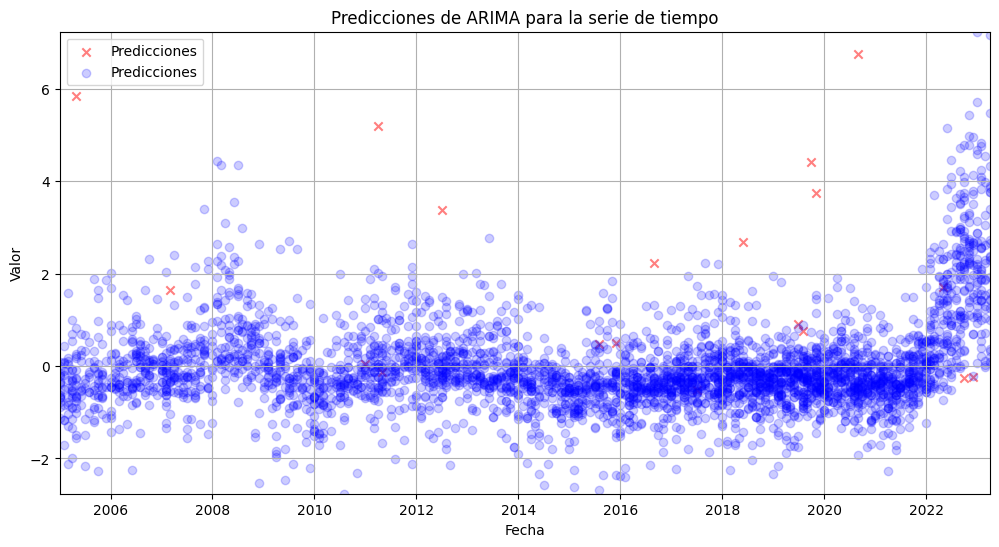

In [81]:
# Graficar los datos reales como puntos individuales
plt.figure(figsize=(12, 6))

# Graficar las predicciones como puntos individuales
plt.scatter(data_to_select_model['ds'][forecast_mean.index], forecast_mean.values, color='red', label='Predicciones', marker='x',alpha=0.5)
# Graficar las predicciones como puntos individuales
plt.scatter(data_to_select_model['ds'][forecast_mean.index], y[forecast_mean.index], color='blue', label='Predicciones', marker='o',alpha=0.2)

# Personalizar el gráfico
plt.title('Predicciones de ARIMA para la serie de tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

plt.xlim(data_to_select_model['ds'].min(), (data_to_select_model['ds'].max()))
plt.ylim(y.min(),y.max())

# Mostrar el gráfico
plt.show()

### MODELO DEEP LEARNING - LSTM

In [82]:
# Supongamos que 'ds' es la columna de fecha y hora en tu DataFrame 'df'
# Vamos a crear nuevas columnas con características de tiempo

data_to_select_model['year'] = data_to_select_model['ds'].dt.year
data_to_select_model['month'] = data_to_select_model['ds'].dt.month

# Luego, puedes eliminar la columna original 'ds' si no la necesitas más
data_to_select_model.drop('ds', axis=1, inplace=True)

# Escalar las columnas numéricas
scaler = StandardScaler()
data_to_select_model[['geo', 'coicop','year','month']] = scaler.fit_transform(data_to_select_model[['geo', 'coicop','year','month']])

data_to_select_model.head()

,coicop,geo,y,year,month
794405,-0.026619,0.561771,-0.499746,0.365038,0.184382
829992,1.170547,-0.590816,1.654324,1.334093,1.047476
784702,-0.475556,0.561771,3.790293,1.334093,1.622871
369100,0.721609,-0.302669,-0.572152,-0.797828,-0.391014
372072,0.871255,-0.734889,0.749253,-0.797828,-1.541806


In [83]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data_to_select_model[['geo', 'coicop', 'year','month']].values
y = data_to_select_model['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de red neuronal
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Flatten())  # Aplanar la salida de la capa LSTM
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluar el modelo en el conjunto de prueba
loss, mae = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, MAE: {mae}')

# Hacer predicciones
predictions = model.predict(X_test)

Epoch 1/100
78/78 [==============================] - 3s 8ms/step - loss: 0.9312 - mae: 0.6491 - val_loss: 0.9794 - val_mae: 0.6798
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.8322 - mae: 0.6314 - val_loss: 0.8498 - val_mae: 0.6552
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 0.7472 - mae: 0.6004 - val_loss: 0.7936 - val_mae: 0.6397
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6884 - mae: 0.5822 - val_loss: 0.7457 - val_mae: 0.6189
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6489 - mae: 0.5666 - val_loss: 0.6860 - val_mae: 0.5849
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6275 - mae: 0.5605 - val_loss: 0.6892 - val_mae: 0.5844
Epoch 7/100
78/78 [==============================] - 0s 4ms/step - loss: 0.6244 - mae: 0.5546 - val_loss: 0.6662 - val_mae: 0.5729
Epoch 8/100
78/78 [==============================] - 0s 2ms/step - loss: 0.6111 - m

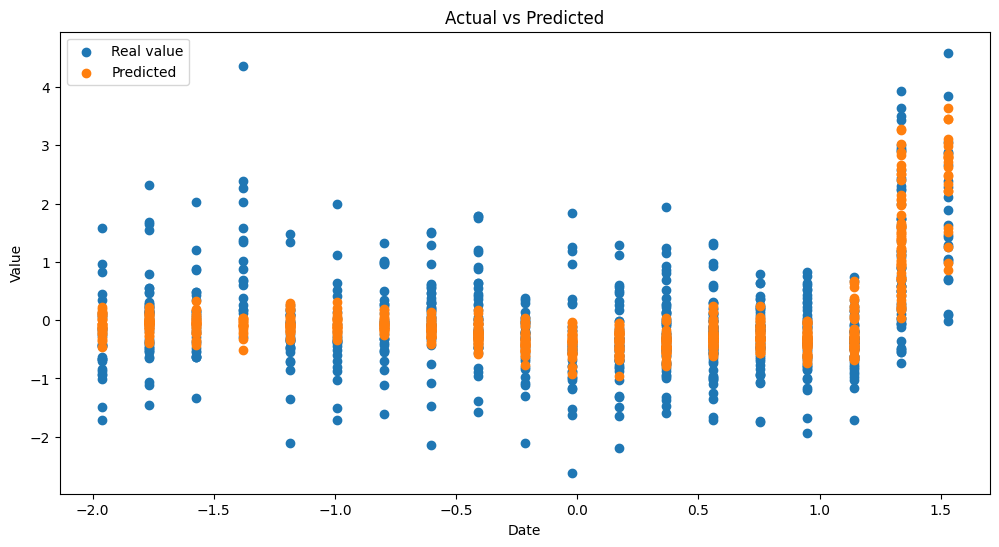

In [84]:
# Crear un DataFrame con las fechas y las predicciones
predictions_df = pd.DataFrame({'Date': X_test[:,2], 'Actual': y_test, 'Predicted': predictions.flatten()})
predictions_df.set_index('Date', inplace=True)

# Graficar las predicciones
plt.figure(figsize=(12, 6))
plt.scatter(predictions_df.index, predictions_df['Actual'], label='Real value', marker='o')
plt.scatter(predictions_df.index, predictions_df['Predicted'], label='Predicted', marker='o')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

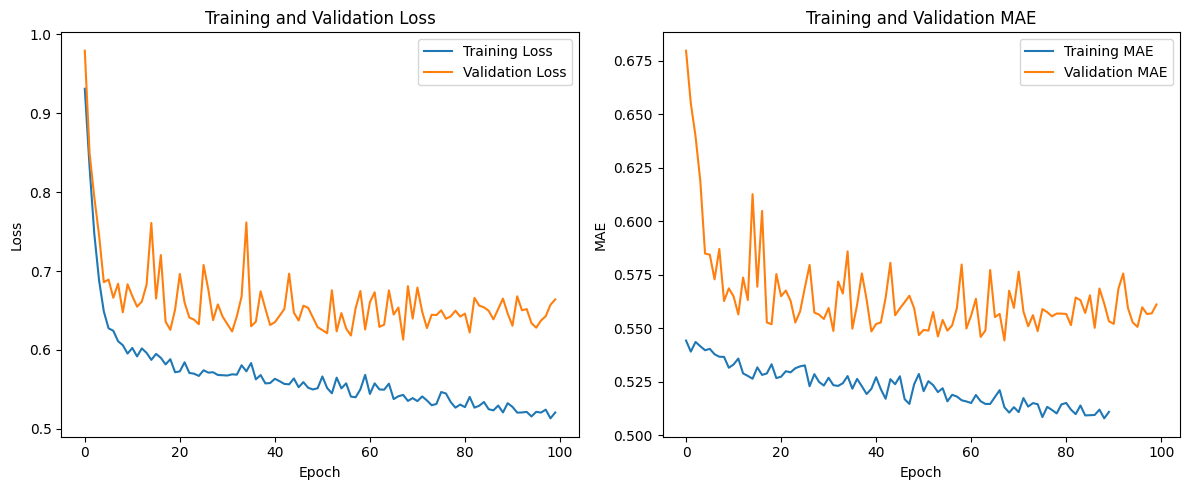

In [85]:
# Obtener las métricas de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae'][10:]
val_mae = history.history['val_mae']

# Crear gráficos de pérdida y MAE durante el entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

## 7.2 DEFINICIÓN DE HIPERPARÁMETROS

In [86]:
def param_analysis(param_grid):

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    df_means = pd.DataFrame()
    times = []
    # Use cross validation to evaluate all parameters
    for params in all_params:
        inicio = time.time()
        model = Prophet(**params)
        model.add_regressor('geo')
        model.add_regressor('coicop')
        m = model.fit(model_data.sample((model_data.shape[0]//20),random_state=19))  # Fit model with given params
        df_cv = cross_validation(m, horizon='365 days')
        df_p = performance_metrics(df_cv, rolling_window=1)
        fin = time.time()
        times.append(fin - inicio)
        # Calcula la media de las métricas en df_p y almacénalas en df_means
        mean_metrics = df_p.mean().to_frame().transpose()
        df_means = df_means.append(mean_metrics, ignore_index=True)
        # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    df_means['times'] = times
    return [tuning_results, df_means]


In [87]:
# Realiza validación cruzada para un mallado de las combinaciones de param_grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0, 3.0, 5.0],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

[tunning_result,metric_means] = param_analysis(param_grid)

15:17:37 - cmdstanpy - INFO - Chain [1] start processing
15:17:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/29 [00:00<?, ?it/s]

15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing
15:17:40 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing
15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:18:22 - cmdstanpy - INFO - Chain [1] start processing
15:18:22 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing
15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing
15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing
15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing
15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing
15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing
15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing
15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:36 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1] done processing
15:18:36 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1] done processing
15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1] done processing
15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1] done processing
15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1] done processing
15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:19:38 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing
15:19:54 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing
15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing
15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing
15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing
15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing
15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing
15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing
15:20:33 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing
15:20:33 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing
15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing
15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing
15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing
15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:21:25 - cmdstanpy - INFO - Chain [1] start processing
15:21:25 - cmdstanpy - INFO - Chain [1] done processing
15:21:25 - cmdstanpy - INFO - Chain [1] start processing
15:21:25 - cmdstanpy - INFO - Chain [1] done processing
15:21:26 - cmdstanpy - INFO - Chain [1] start processing
15:21:26 - cmdstanpy - INFO - Chain [1] done processing
15:21:26 - cmdstanpy - INFO - Chain [1] start processing
15:21:26 - cmdstanpy - INFO - Chain [1] done processing
15:21:26 - cmdstanpy - INFO - Chain [1] start processing
15:21:27 - cmdstanpy - INFO - Chain [1] done processing
15:21:27 - cmdstanpy - INFO - Chain [1] start processing
15:21:27 - cmdstanpy - INFO - Chain [1] done processing
15:21:27 - cmdstanpy - INFO - Chain [1] start processing
15:21:28 - cmdstanpy - INFO - Chain [1] done processing
15:21:28 - cmdstanpy - INFO - Chain [1] start processing
15:21:29 - cmdstanpy - INFO - Chain [1] done processing
15:21:29 - cmdstanpy - INFO - Chain [1] start processing
15:21:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:21:51 - cmdstanpy - INFO - Chain [1] start processing
15:21:51 - cmdstanpy - INFO - Chain [1] done processing
15:21:51 - cmdstanpy - INFO - Chain [1] start processing
15:21:51 - cmdstanpy - INFO - Chain [1] done processing
15:21:51 - cmdstanpy - INFO - Chain [1] start processing
15:21:51 - cmdstanpy - INFO - Chain [1] done processing
15:21:52 - cmdstanpy - INFO - Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing
15:21:52 - cmdstanpy - INFO - Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing
15:21:52 - cmdstanpy - INFO - Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing
15:21:53 - cmdstanpy - INFO - Chain [1] start processing
15:21:53 - cmdstanpy - INFO - Chain [1] done processing
15:21:53 - cmdstanpy - INFO - Chain [1] start processing
15:21:53 - cmdstanpy - INFO - Chain [1] done processing
15:21:53 - cmdstanpy - INFO - Chain [1] start processing
15:21:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:22:09 - cmdstanpy - INFO - Chain [1] start processing
15:22:09 - cmdstanpy - INFO - Chain [1] done processing
15:22:10 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing
15:22:10 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing
15:22:10 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing
15:22:10 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:12 - cmdstanpy - INFO - Chain [1] done processing
15:22:12 - cmdstanpy - INFO - Chain [1] start processing
15:22:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:22:27 - cmdstanpy - INFO - Chain [1] start processing
15:22:27 - cmdstanpy - INFO - Chain [1] done processing
15:22:27 - cmdstanpy - INFO - Chain [1] start processing
15:22:27 - cmdstanpy - INFO - Chain [1] done processing
15:22:28 - cmdstanpy - INFO - Chain [1] start processing
15:22:28 - cmdstanpy - INFO - Chain [1] done processing
15:22:28 - cmdstanpy - INFO - Chain [1] start processing
15:22:28 - cmdstanpy - INFO - Chain [1] done processing
15:22:28 - cmdstanpy - INFO - Chain [1] start processing
15:22:28 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:30 - cmdstanpy - INFO - Chain [1] start processing
15:22:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:22:46 - cmdstanpy - INFO - Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing
15:22:46 - cmdstanpy - INFO - Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing
15:22:46 - cmdstanpy - INFO - Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing
15:22:47 - cmdstanpy - INFO - Chain [1] start processing
15:22:47 - cmdstanpy - INFO - Chain [1] done processing
15:22:47 - cmdstanpy - INFO - Chain [1] start processing
15:22:47 - cmdstanpy - INFO - Chain [1] done processing
15:22:47 - cmdstanpy - INFO - Chain [1] start processing
15:22:47 - cmdstanpy - INFO - Chain [1] done processing
15:22:48 - cmdstanpy - INFO - Chain [1] start processing
15:22:48 - cmdstanpy - INFO - Chain [1] done processing
15:22:48 - cmdstanpy - INFO - Chain [1] start processing
15:22:48 - cmdstanpy - INFO - Chain [1] done processing
15:22:48 - cmdstanpy - INFO - Chain [1] start processing
15:22:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:23:04 - cmdstanpy - INFO - Chain [1] start processing
15:23:04 - cmdstanpy - INFO - Chain [1] done processing
15:23:04 - cmdstanpy - INFO - Chain [1] start processing
15:23:04 - cmdstanpy - INFO - Chain [1] done processing
15:23:04 - cmdstanpy - INFO - Chain [1] start processing
15:23:04 - cmdstanpy - INFO - Chain [1] done processing
15:23:05 - cmdstanpy - INFO - Chain [1] start processing
15:23:05 - cmdstanpy - INFO - Chain [1] done processing
15:23:05 - cmdstanpy - INFO - Chain [1] start processing
15:23:05 - cmdstanpy - INFO - Chain [1] done processing
15:23:05 - cmdstanpy - INFO - Chain [1] start processing
15:23:05 - cmdstanpy - INFO - Chain [1] done processing
15:23:06 - cmdstanpy - INFO - Chain [1] start processing
15:23:06 - cmdstanpy - INFO - Chain [1] done processing
15:23:06 - cmdstanpy - INFO - Chain [1] start processing
15:23:06 - cmdstanpy - INFO - Chain [1] done processing
15:23:06 - cmdstanpy - INFO - Chain [1] start processing
15:23:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:23:22 - cmdstanpy - INFO - Chain [1] start processing
15:23:22 - cmdstanpy - INFO - Chain [1] done processing
15:23:22 - cmdstanpy - INFO - Chain [1] start processing
15:23:22 - cmdstanpy - INFO - Chain [1] done processing
15:23:22 - cmdstanpy - INFO - Chain [1] start processing
15:23:22 - cmdstanpy - INFO - Chain [1] done processing
15:23:23 - cmdstanpy - INFO - Chain [1] start processing
15:23:23 - cmdstanpy - INFO - Chain [1] done processing
15:23:23 - cmdstanpy - INFO - Chain [1] start processing
15:23:23 - cmdstanpy - INFO - Chain [1] done processing
15:23:23 - cmdstanpy - INFO - Chain [1] start processing
15:23:23 - cmdstanpy - INFO - Chain [1] done processing
15:23:24 - cmdstanpy - INFO - Chain [1] start processing
15:23:24 - cmdstanpy - INFO - Chain [1] done processing
15:23:24 - cmdstanpy - INFO - Chain [1] start processing
15:23:24 - cmdstanpy - INFO - Chain [1] done processing
15:23:25 - cmdstanpy - INFO - Chain [1] start processing
15:23:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:23:41 - cmdstanpy - INFO - Chain [1] start processing
15:23:41 - cmdstanpy - INFO - Chain [1] done processing
15:23:41 - cmdstanpy - INFO - Chain [1] start processing
15:23:41 - cmdstanpy - INFO - Chain [1] done processing
15:23:41 - cmdstanpy - INFO - Chain [1] start processing
15:23:42 - cmdstanpy - INFO - Chain [1] done processing
15:23:42 - cmdstanpy - INFO - Chain [1] start processing
15:23:42 - cmdstanpy - INFO - Chain [1] done processing
15:23:42 - cmdstanpy - INFO - Chain [1] start processing
15:23:42 - cmdstanpy - INFO - Chain [1] done processing
15:23:43 - cmdstanpy - INFO - Chain [1] start processing
15:23:43 - cmdstanpy - INFO - Chain [1] done processing
15:23:43 - cmdstanpy - INFO - Chain [1] start processing
15:23:43 - cmdstanpy - INFO - Chain [1] done processing
15:23:44 - cmdstanpy - INFO - Chain [1] start processing
15:23:44 - cmdstanpy - INFO - Chain [1] done processing
15:23:44 - cmdstanpy - INFO - Chain [1] start processing
15:23:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

15:24:09 - cmdstanpy - INFO - Chain [1] start processing
15:24:09 - cmdstanpy - INFO - Chain [1] done processing
15:24:09 - cmdstanpy - INFO - Chain [1] start processing
15:24:09 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing
15:24:10 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing
15:24:10 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing
15:24:11 - cmdstanpy - INFO - Chain [1] done processing
15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:11 - cmdstanpy - INFO - Chain [1] done processing
15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:12 - cmdstanpy - INFO - Chain [1] done processing
15:24:12 - cmdstanpy - INFO - Chain [1] start processing
15:24:12 - cmdstanpy - INFO - Chain [1] done processing
15:24:12 - cmdstanpy - INFO - Chain [1] start processing
15:24:13 - cmdstanpy - INFO - Chain [1]

In [ ]:
tunning_result[metric_means.columns] = metric_means
tunning_result.drop(columns='horizon',axis=1,inplace=True)

In [ ]:
tunning_result.head()

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mse,rmse,mae,mape,mdape,smape,coverage,times
0,0.01,0.001,additive,0.89987,0.948615,0.629874,2.316665,0.985967,1.286352,0.812414,9.979465
1,0.01,0.001,multiplicative,0.910516,0.95421,0.633517,2.35373,0.989199,1.294267,0.813634,10.089813
2,0.01,0.010,additive,0.899899,0.94863,0.631006,2.329017,0.996175,1.287849,0.815007,9.928313
3,0.01,0.010,multiplicative,0.908868,0.953346,0.632305,2.354566,0.984725,1.284941,0.811804,10.215381
4,0.01,0.100,additive,0.907157,0.952448,0.634113,2.35591,0.99888,1.283574,0.813634,10.000009


<AxesSubplot: title={'center': 'rmse'}, ylabel='Frequency'>

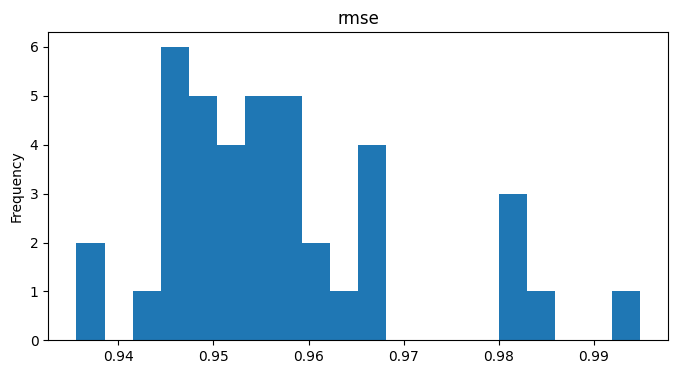

In [ ]:
tunning_result['rmse'].plot(kind='hist', bins=20, title='rmse', figsize=(8, 4))

In [ ]:
tunning_result['times'].plot(kind='hist', bins=20, title='times', figsize=(8, 4))

NameError: name 'tunning_result' is not defined

In [ ]:
best_params = tunning_result[tunning_result['rmse'] < 0.95]
best_params.sort_values(by ='rmse')

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mse,rmse,mae,mape,mdape,smape,coverage,times
38,5.00,1.000,additive,0.875323,0.935587,0.63529,2.657796,0.949744,1.240055,0.808144,19.588064
36,5.00,0.100,additive,0.879608,0.937874,0.634392,2.630309,0.944493,1.23478,0.803264,19.028497
30,3.00,1.000,additive,0.889778,0.94328,0.639566,2.687816,0.94663,1.238029,0.794723,20.080878
28,3.00,0.100,additive,0.893414,0.945206,0.638202,2.66411,0.945101,1.234978,0.794723,19.506927
16,1.00,0.001,additive,0.894747,0.945911,0.637734,2.709299,0.906785,1.207315,0.790453,25.849561
18,1.00,0.010,additive,0.896287,0.946724,0.640038,2.718663,0.922348,1.217369,0.789233,17.100919
24,3.00,0.001,additive,0.896466,0.946819,0.637032,2.642639,0.940134,1.23229,0.797468,26.709252
20,1.00,0.100,additive,0.896503,0.946838,0.641335,2.747379,0.924993,1.217581,0.788165,16.874582
26,3.00,0.010,additive,0.897167,0.947189,0.638236,2.651132,0.942501,1.234205,0.797621,19.940379
32,5.00,0.001,additive,0.898542,0.947915,0.637306,2.639509,0.943581,1.234274,0.799298,24.731940


In [ ]:
best_params.iloc[np.argmin(best_params['rmse']),:3]

changepoint_prior_scale         5.0
seasonality_prior_scale         1.0
seasonality_mode           additive
Name: 38, dtype: object

In [ ]:
best_params_grid = {
    'changepoint_prior_scale': 5,
    'seasonality_prior_scale': 1.0,
    'seasonality_mode': 'additive',
    'weekly_seasonality': False,
    'daily_seasonality': False
}

In [ ]:
print(f"La configuración con menor rmse:")
print(f"changepoint_prior_scale = {best_params_grid['changepoint_prior_scale']}, seasonality_prior_scale =  {best_params_grid['seasonality_prior_scale']} seasonality_mode = {best_params_grid['seasonality_mode']}")
print(f"El tiempo de ejecución ha sido {best_params.loc[38]['times']} segundos")
print(f"El valor de RMSE obtenido es de: {best_params['rmse'].iloc[np.argmin(best_params['rmse'])]} ")


La configuración con menor rmse:
changepoint_prior_scale = 5, seasonality_prior_scale =  1.0 seasonality_mode = additive
El tiempo de ejecución ha sido 19.588063716888428 segundos
El valor de RMSE obtenido es de: 0.935586722240893 


## 7.3 SELECCIÓN TRAIN/TEST SIZE

In [ ]:
df_means_ts = pd.DataFrame()
times = []
for train_size in  [0.5,0.6,0.7,0.8]:
    # Creación de modelo
    inicio = time.time()
    model = Prophet(**best_params_grid)
    model.add_regressor('geo')
    model.add_regressor('coicop')

    # Split de datos
    df_train, df_test = train_test_split(model_data.sample(model_data.shape[0]//10), train_size= train_size, shuffle=False, random_state=42)
    df_train.head()

    # Entrenamiento
    model.fit(df_train)

    fin = time.time()

    # Realiza la validación cruzada
    df_cv_ts = cross_validation(model,horizon='365 days')
    df_p_ts = performance_metrics(df_cv_ts,rolling_window=1)
    mean_metrics_ts = df_p_ts.mean().to_frame().transpose()
    df_means_ts = df_means_ts.append(mean_metrics_ts, ignore_index=True)
    times.append(fin - inicio)

19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/29 [00:00<?, ?it/s]19:15:54 - cmdstanpy - INFO - Chain [1] start processing
19:15:54 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 1/29 [00:00<00:08,  3.24it/s]19:15:54 - cmdstanpy - INFO - Chain [1] start processing
19:15:54 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 2/29 [00:00<00:08,  3.28it/s]19:15:54 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 3/29 [00:00<00:08,  3.23it/s]19:15:55 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 4/29 [00:01<00:08,  3.07it/s]19:15:55 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 5/29 [00:01<00:08,  2.88it/s]19:15:55 - cmdstanpy - INFO - Chain [1] start processi

In [ ]:
df_means_ts.index = [0.5,0.6,0.7,0.8]
df_means_ts.index.name = 'Train Size'
df_means_ts.drop(columns='horizon',axis=1,inplace=True)
df_means_ts['time'] = times

In [ ]:
df_means_ts

,mse,rmse,mae,mape,mdape,smape,coverage,time
Train Size,,,,,,,,
0.5,0.948859,0.974094,0.653538,2.819496,0.906801,1.202732,0.800426,1.181133
0.6,0.94304,0.971103,0.664655,2.673915,0.964967,1.26597,0.783946,1.441659
0.7,0.905876,0.951775,0.645575,2.476388,0.928881,1.242892,0.789537,1.936084
0.8,0.978139,0.989009,0.677101,2.623764,0.901954,1.222943,0.79754,1.817170


In [ ]:
final_train_size = df_means_ts.index[np.argmin(df_means_ts['rmse'])]
print(f"El tamaño de train size escogido es: {final_train_size}")

El tamaño de train size escogido es: 0.7


In [ ]:
print(f"El número de registros utilizados para entrenamiento será: {final_train_size * model_data.shape[0]//1}")

El número de registros utilizados para entrenamiento será: 54312.0


# 8. MODELO FINAL

In [ ]:
print("Los hiperparámetros utilizados para entrenar el modelo son:")
best_params_grid
print(f"El train_size utilizado será: {final_train_size}")

Los hiperparámetros utilizados para entrenar el modelo son:
El train_size utilizado será: 0.7


In [ ]:
df_means = pd.DataFrame()
# Creación de modelo
inicio = time.time()
final_model = Prophet(**best_params_grid)
final_model.add_regressor('geo')
final_model.add_regressor('coicop')

# Split de datos
df_train, df_test = train_test_split(model_data, test_size=1 - final_train_size, shuffle=True, random_state=19)

inicio = time.time()
# Entrenamiento
final_model.fit(df_train)

19:17:24 - cmdstanpy - INFO - Chain [1] start processing
19:17:49 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Definir los valores de initial, period y horizon
initial = f"{365*10} days"
period = "30 days"
horizon = f"{365*5} days"

# Realizar la validación cruzada
df_cv = cross_validation(final_model, initial=initial, period=period, horizon=horizon)
df_p = performance_metrics(df_cv)

fin = time.time()
mean_metrics = df_p.mean()

  0%|          | 0/40 [00:00<?, ?it/s]19:17:53 - cmdstanpy - INFO - Chain [1] start processing
19:17:58 - cmdstanpy - INFO - Chain [1] done processing
  2%|▎         | 1/40 [00:09<05:57,  9.17s/it]19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 2/40 [00:19<06:19,  9.99s/it]19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 3/40 [00:30<06:18, 10.23s/it]19:18:23 - cmdstanpy - INFO - Chain [1] start processing
19:18:28 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 4/40 [00:39<05:58,  9.95s/it]19:18:33 - cmdstanpy - INFO - Chain [1] start processing
19:18:38 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 5/40 [00:49<05:46,  9.90s/it]19:18:42 - cmdstanpy - INFO - Chain [1] start processing
19:18:48 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 6/40 [00:59<05:33,  9.81s/it]19:18:52

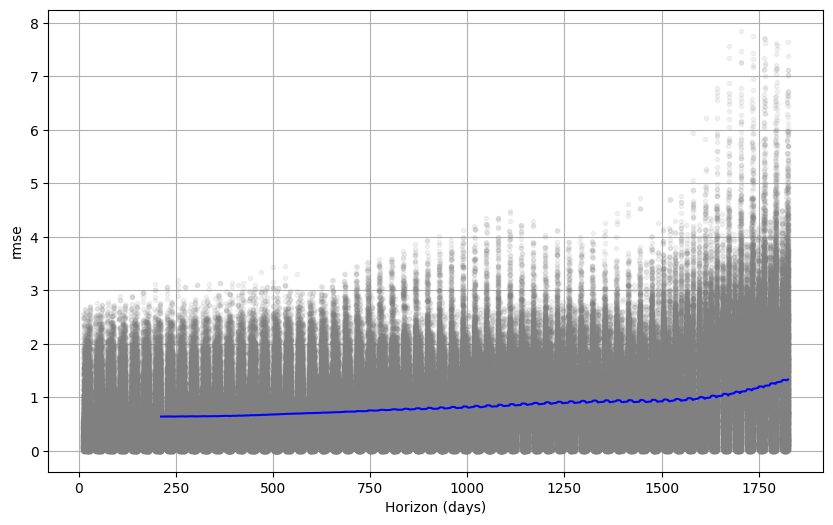

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
mean_metrics

horizon     1029 days 18:19:01.463414640
mse                             0.746234
rmse                            0.848587
mae                             0.634928
mape                            3.498907
mdape                           1.130105
smape                           1.268864
coverage                        0.967377
dtype: object

In [ ]:
print(f"El tiempo de ejecucion ha sido {fin-inicio}")

El tiempo de ejecucion ha sido 530.7770869731903


In [ ]:
# Crear un rango de fechas mensuales desde enero de 2015 hasta enero de 2020
fecha_inicio = "2015-01-01"
fecha_fin = "2020-01-01"


In [ ]:
# Filtra las predicciones dentro del intervalo deseado
predicciones_intervalo = df_test[(df_test['ds'] >= fecha_inicio) & (df_test['ds'] <= fecha_fin)]

# Evaluación
forecast_all = final_model.predict(predicciones_intervalo)
# Evaluación
forecast_food = final_model.predict(predicciones_intervalo[predicciones_intervalo['coicop'] == 1])
# Evaluación
forecast_esp = final_model.predict(predicciones_intervalo[predicciones_intervalo['geo'] == 13])

In [ ]:


# Crear un DataFrame vacío para almacenar las métricas
metricas_df = pd.DataFrame(columns=['Modelo', 'MSE', 'RMSE','MAE','Size'])

# Definir una función para calcular las métricas y agregarlas al DataFrame
def calcular_metricas(nombre_modelo, y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    size = y_pred.shape[0]
    metricas_df.loc[len(metricas_df)] = [nombre_modelo, mse, rmse,mae,size]

# Calcular y agregar las métricas para los tres conjuntos de pronósticos
calcular_metricas('forecast_all', predicciones_intervalo['y'], forecast_all['yhat'])
calcular_metricas('forecast_food', predicciones_intervalo[df_test['coicop'] == 1]['y'], forecast_food['yhat'])
calcular_metricas('forecast_esp', predicciones_intervalo[df_test['geo'] == 13]['y'], forecast_esp['yhat'])


C:\Users\David\AppData\Local\Temp\ipykernel_8552\3960817630.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  calcular_metricas('forecast_food', predicciones_intervalo[df_test['coicop'] == 1]['y'], forecast_food['yhat'])
C:\Users\David\AppData\Local\Temp\ipykernel_8552\3960817630.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  calcular_metricas('forecast_esp', predicciones_intervalo[df_test['geo'] == 13]['y'], forecast_esp['yhat'])


In [ ]:
metricas_df

,Modelo,MSE,RMSE,MAE,Size
0,forecast_all,0.388932,0.623644,0.449237,8062
1,forecast_food,0.126578,0.355778,0.274359,477
2,forecast_esp,0.138860,0.372639,0.263790,394


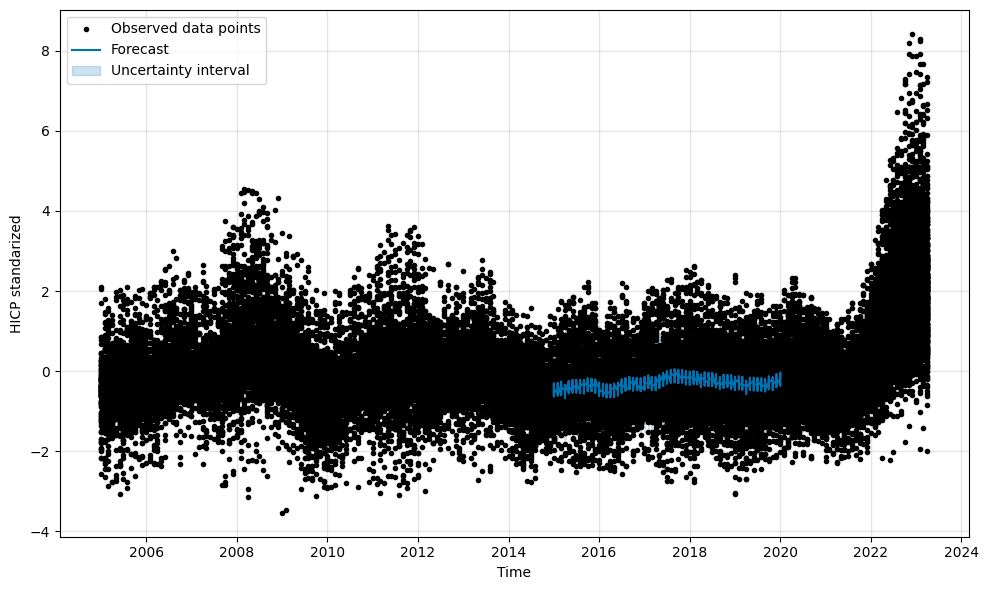

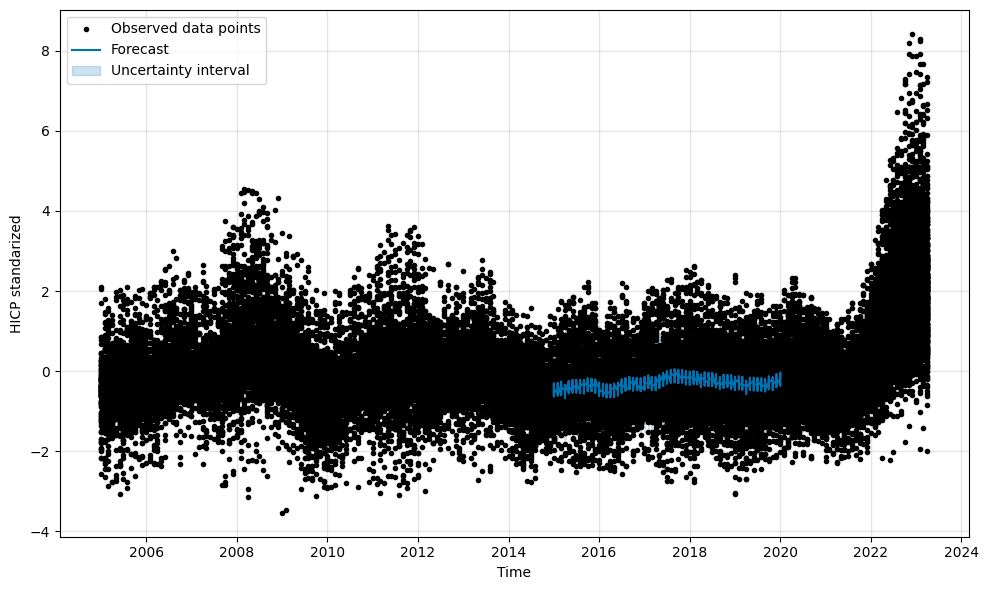

In [ ]:
final_model.plot(forecast_all,xlabel='Time',ylabel='HICP standarized',include_legend=True,uncertainty=True)